# Example 3: Toy example of a PAT autodifferentiable function

The scope of this notebook is to show, with as little coding overhead as possible, the implementation of Physics-Aware-Training. For this purpose, a simple function, $f(x) = 2x^{1.1}$, and an imperfect model for said function, $f_m(x) = 2.01x^{1.1}$, is considered. The growth of the simulation-reality gap between $f$ and $f_m$ in forward- and backward-mode is explored. This function is further discussed in the Supplementary Material, Section I.A.

In [1]:
import matplotlib.pyplot as plt

## Simulation-reality gap in forward mode

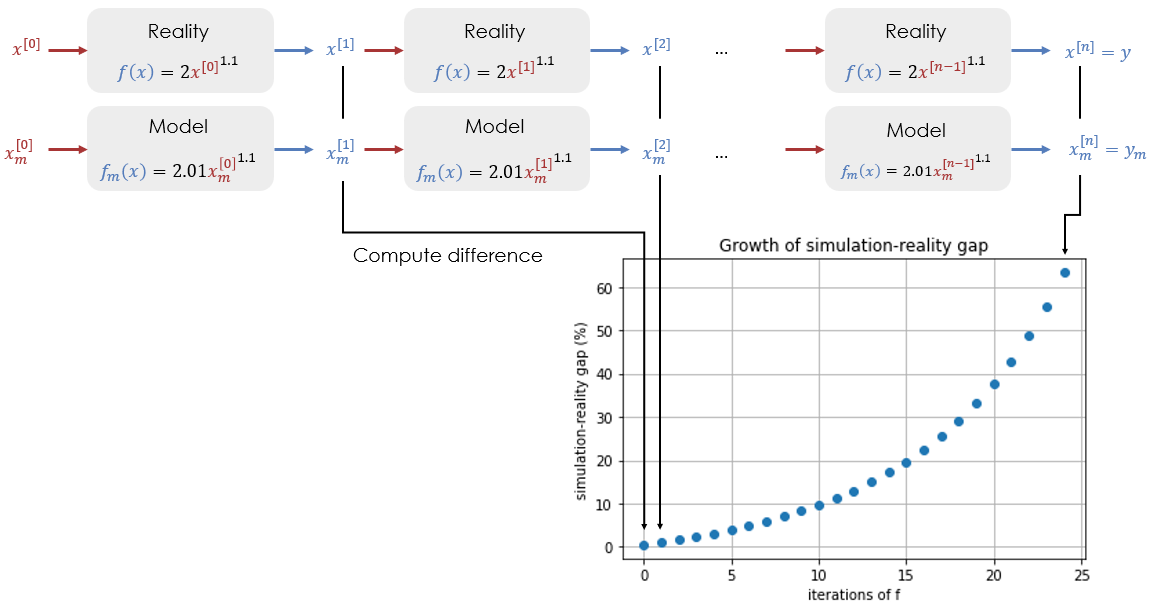

First, it is simply observed that for repeated application of a function and its model, as occurs in a deep network or general hierarchical process,
small inaccuracies of the model blow-up. For n = 1, the simulation-reality gap (the relative error in the model’s
output compared to the reality) is about 0.5%. For n = 5, it has grown to 3%. By n = 20, the gap is 30%. Of course,
this is only a toy example: the blow-up depends, among other things, on the function, where it is evaluated, and how
and where the model is inaccurate. The key point is that the model is increasingly wrong as the depth increases

In [2]:
# helper function to compute the relative distance of x2 to x1 in percent and append it to gap_list
compute_gap = lambda x1, x2, gap_list : gap_list.append(100*(x2 - x1)/x1)

Define 'reality' and a differentiable model of 'reality':

In [3]:
def f(x, theta=1.1):
    # 'reality'
    return 2*x**theta

def f_m(x, theta=1.1):
    # 'differentiable model' or 'simulation'
    return 2.01*x**theta

Iteratively apply function $f$ and $f_m$ on the same initial condition $x^{[0]}=1$ and observe the exponential growth of the simulation-reality gap:


In [4]:
n_range = range(25) # number of iterations for function f
gap_list = []

for n in n_range:
    # set equal initial conditions
    x = 1.
    x_m = x
    
    for i in range(n):
        x = f(x)
        x_m = f_m(x_m)
    
    compute_gap(x, x_m, gap_list)

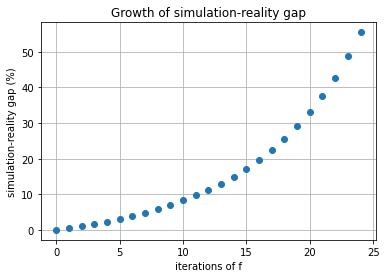

In [5]:
plt.title('Growth of simulation-reality gap')
plt.plot(n_range, gap_list, 'o')
plt.ylabel('simulation-reality gap (%)')
plt.xlabel('iterations of f')
plt.grid()

## Simulation-reality gap of gradients and its suppression by PAT

Three different methods of estimating the gradient of $y$ with respect to the initial input $x_0$ are implemented and compared. 

#### True gradients
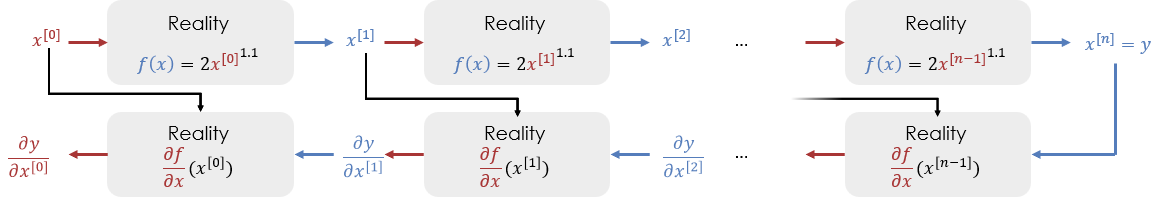
Gradients are exact but this method is not accessible in experiments.

#### In silico gradient estimation
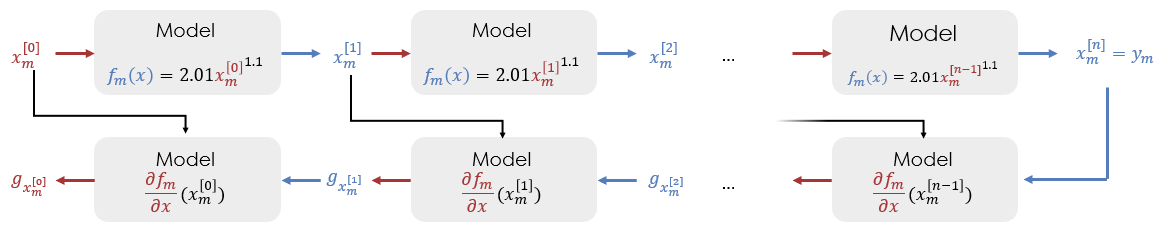
Gradients are backpropagated via the differentiable model without feedback from the experiment.

#### PAT gradient estimation
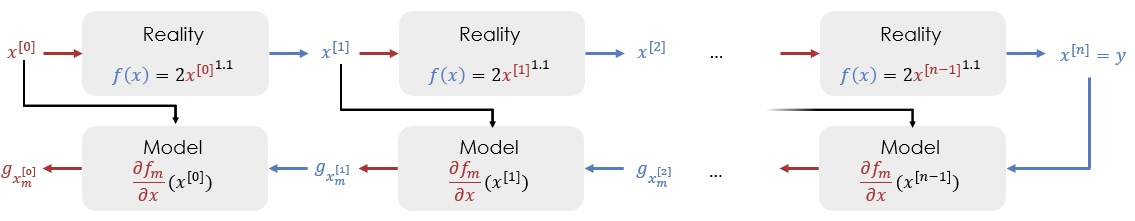
Gradients are backpropagated via the differentiable model that is evaluated at experimental outputs.

For more detail, please see the Supplementary Material, Section I.B.

In [6]:
import torch, copy
from pat import make_pat_func

In [7]:
# define a custom autodifferentiable 
f_autodiff = make_pat_func(f, f_m)

In [8]:
in_silico_grad_gaps, PAT_grad_gaps = [], []

for n in n_range:
    # Set equal initial conditions for all three methods of gradient estimation
    x_init = torch.tensor(1., requires_grad = True)
    x_m_init, x_PAT_init = copy.copy(x_init), copy.copy(x_init)
    x, x_m, x_PAT = x_init, x_m_init, x_PAT_init

    # perform n forward and backward passes using all three methods
    for i in range(n):
        x = f(x)
        x_m = f_m(x_m)
        x_PAT = f_autodiff(x_PAT)
    
    x.backward()
    x_m.backward()
    x_PAT.backward()
    
    # compute the simulation-reality gap and save in list
    compute_gap(x_init.grad, x_m_init.grad, in_silico_grad_gaps)
    compute_gap(x_init.grad, x_PAT_init.grad, PAT_grad_gaps)

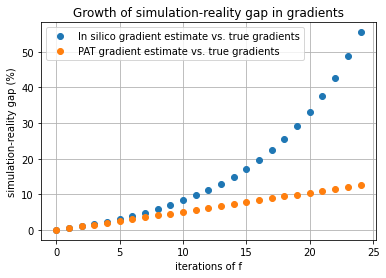

In [9]:
plt.title('Growth of simulation-reality gap in gradients')
plt.plot(n_range, in_silico_grad_gaps, 'o', label = 'In silico gradient estimate vs. true gradients')
plt.plot(n_range, PAT_grad_gaps, 'o', label = 'PAT gradient estimate vs. true gradients')
plt.ylabel('simulation-reality gap (%)')
plt.xlabel('iterations of f')
plt.legend()
plt.grid()

The growth of the simulation-reality gap between true and estimated gradients, with respect to the number of iterations of $f$, is exponentially suppressed by PAT when compared to in silico gradient estimation in this simple toy example.

## Comparison of training performance on a toy task

Update $\theta$ with gradient descent and attempt for $y=f^N(x^{[0]}, \theta)$ to approach the target $t$. Compare the performance of in silico and PAT gradient estimation in this task.
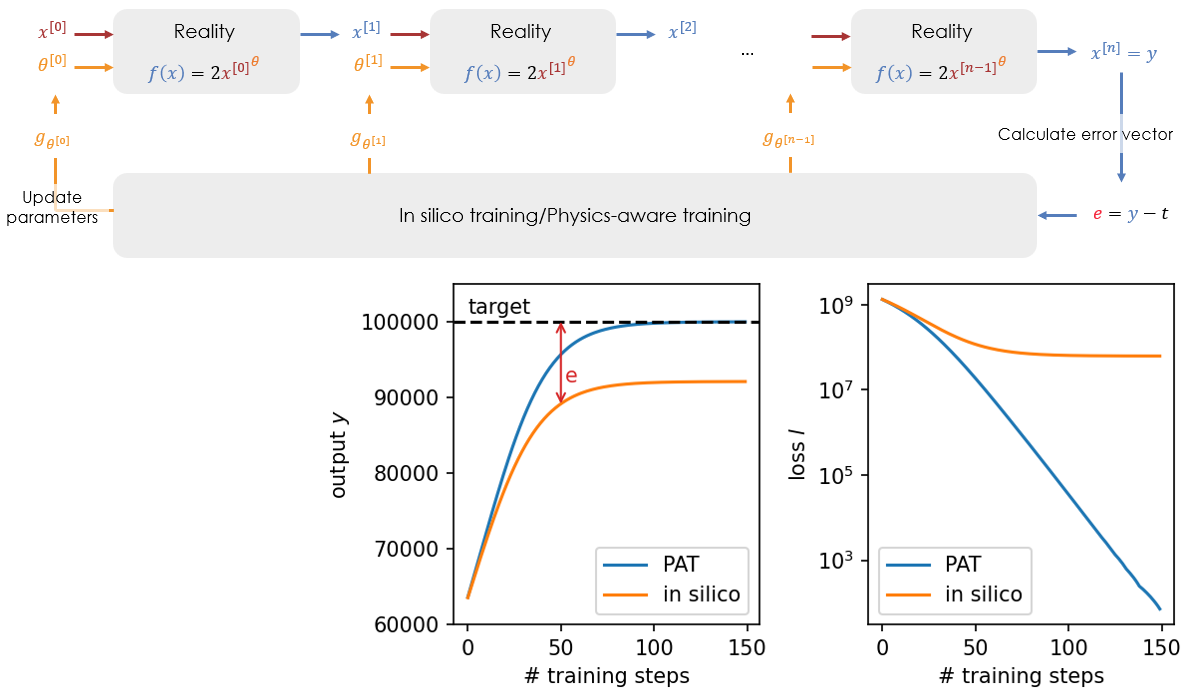

In [10]:
import torch.nn as nn
import torch.nn.functional as F

Define a `nn.Module` that applies $f$ (PAT) or $f_m$ (in silico training) 10 times in forward mode and uses $f_m$ in backward mode.

In [11]:
class Net(nn.Module):
    def __init__(self, PAT = True):
        super(Net, self).__init__()
        self.theta = nn.Parameter(torch.tensor([1.1]))
        self.n_range = range(10) # number of iterations for function f
        if PAT: self.f = f_autodiff
        else: self.f = f_m
        
    def forward(self, x):
        for i in self.n_range:
            x = self.f(x, self.theta)
        return x

This extremely simplified training loop uses stochastic gradient descent with just a single training point $(x = 1, t = 10^5)$. After performing a gradient descent update step, it computes the output and loss using the 'reality' function and saves those in two lists:

In [12]:
def training_loop(x, target, net):
    loss_per_step = []
    output_per_step = []
    # Because of the strong exponential growth of the example function, the learning rate
    # was manually tuned to be this small.
    optimizer = torch.optim.SGD(net.parameters(), lr = 1e-15)
    
    for i in range(n_training_steps):
        y = net(x)
        loss = F.mse_loss(y, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # also compute and save the output of the 'reality' forward pass
        # with the current parameter theta. The net_PAT can be used to achieve 
        # this as PAT uses the 'reality' function in forward mode
        net_reality = Net(PAT = True)
        net_reality.theta = net.theta
        y_reality = net_reality(x)
        output_per_step.append(y_reality)
        # save the 'real' (!) loss at each training step
        loss = F.mse_loss(y_reality, target)
        loss_per_step.append(loss.detach())
    return loss_per_step, output_per_step

In [13]:
# define a single training point
x = torch.tensor([1.], requires_grad = False)
target = torch.tensor([100000.])
n_training_steps = 150

In [14]:
# train a network with PAT
net_PAT = Net(PAT = True)
loss_per_step_PAT, output_per_step_PAT =  training_loop(x, target, net_PAT)

# train a network with in_silico training
net_in_silico = Net(PAT = False)
loss_per_step_in_silico, output_per_step_in_silico = training_loop(x, target, net_in_silico)

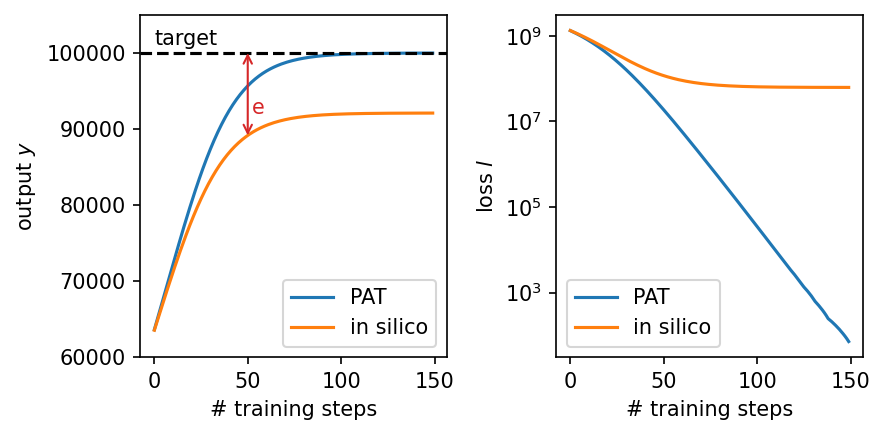

In [15]:
plt.figure(figsize = [6,3], dpi = 150)

plt.subplot(1,2,1)
plt.plot(output_per_step_PAT, label = 'PAT')
plt.plot(output_per_step_in_silico, label = 'in silico')
plt.axhline(target, ls = '--', color = 'k')
plt.text(0, 1.01e5, 'target')
plt.ylim(6e4, 1.05e5)
plt.xlabel('# training steps')
plt.ylabel(r'output $y$')
plt.annotate(s='', 
             xy=(50,output_per_step_in_silico[50]), 
             xytext=(50,target),
             arrowprops=dict(arrowstyle='<->', shrinkA = 0, shrinkB = 0, color = 'tab:red'),
             color = 'r')
plt.text(52, 0.92e5, 'e', color = 'tab:red')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_per_step_PAT, label = 'PAT')
plt.plot(loss_per_step_in_silico, label = 'in silico')
plt.yscale('log')
plt.xlabel('# training steps')
plt.ylabel(r'loss $l$')
plt.legend()

plt.tight_layout()

Even though PAT only has access to an imperfect differentiable model of reality, it manages to train the exponent $\theta$ accurately. In silico training, not using the 'real' outputs from $f$ fails to train $\theta$ accurately and the loss between PAT and in silico training diverges with increasing training steps.